训练集的 batch 数量: 782，每个 batch 中的数据数量: 64
测试集的 batch 数量: 157，每个 batch 中的数据数量: 64


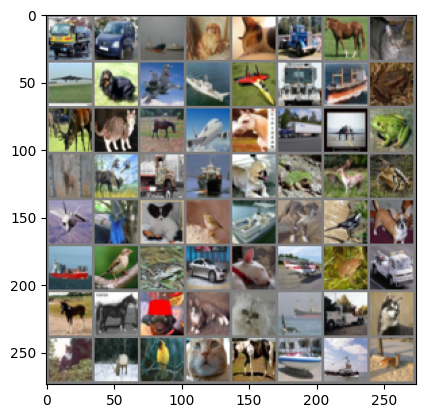

truck car   ship  dog   cat   truck horse cat   plane dog  


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torch
# 下载数据集的路径
path = './DataSet'
# 使用的设备
device = torch.device("cuda")
# 数据预处理,转换为张量并归一化
transform = transforms.Compose([
    transforms.ToTensor(),  # 将图像转换为张量
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # 归一化处理

train_set = CIFAR10(root=path, train=True, download=True, transform=transform)
test_set = CIFAR10(root=path, train=False, download=True, transform=transform)
# 加载数据集并设置批次大小
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
# 修正 print 语句，明确输出内容
print(f"训练集的 batch 数量: {len(train_loader)}，每个 batch 中的数据数量: {train_loader.batch_size}")
print(f"测试集的 batch 数量: {len(test_loader)}，每个 batch 中的数据数量: {test_loader.batch_size}")

# 图片可视化
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
import matplotlib.pyplot as plt # type: ignore
import numpy as np
import torchvision # pyright: ignore[reportMissingImports]

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(10)))

In [2]:
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

# 神经网络模型
class CIFAR10_Net(Module):
    def __init__(self, n_channels):
        super().__init__()
        # 卷积层 1：输入通道数为 n_channels，输出通道数为 6，卷积核大小为 3x3
        self.conv1 = Conv2d(n_channels, 6, (5, 5))
        # 使用 Kaiming 初始化方法初始化卷积层 1 的权重，适用于 ReLU 激活函数
        kaiming_uniform_(self.conv1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # 池化层 1：使用 2x2 的最大池化，步长为 2
        self.pool1 = MaxPool2d((2, 2), stride=(2, 2))
        # 卷积层 2：输入通道数为 6，输出通道数为 16，卷积核大小为 5x5
        self.conv2 = Conv2d(6, 16, (5, 5))
        # 使用 Kaiming 初始化方法初始化卷积层 2 的权重，适用于 ReLU 激活函数
        kaiming_uniform_(self.conv2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # 全连接层 1：输入维度为 16*5*5，输出维度为 120
        self.fc1 = Linear(16 * 5 * 5, 120)
        # 使用 Kaiming 初始化方法初始化全连接层 1 的权重，适用于 ReLU 激活函数
        kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.act3 = ReLU()
        # 全连接层 2：输入维度为 120，输出维度为 84
        self.fc2 = Linear(120, 84)
        # 使用 Kaiming 初始化方法初始化全连接层 2 的权重，适用于 ReLU 激活函数
        kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        self.act4 = ReLU()
        # 输出层：输入维度为 84，输出维度为 10，对应 CIFAR-10 的 10 个类别
        self.fc3 = Linear(84, 10)
        # 使用 Xavier 初始化方法初始化输出层的权重
        xavier_uniform_(self.fc3.weight)

    # 前向传播
    def forward(self, x):
        # 卷积层 1
        x = self.conv1(x)
        x = self.act1(x)
        # 池化层 1
        x = self.pool1(x)
        # 卷积层 2
        x = self.conv2(x)
        x = self.act2(x)
        # 池化层 2
        x = self.pool1(x)
        # 扁平化
        x = x.view(-1, 16 * 5 * 5)
        # 全连接层 1
        x = self.fc1(x)
        x = self.act3(x)
        # 全连接层 2
        x = self.fc2(x)
        x = self.act4(x)
        # 输出层
        x = self.fc3(x)
        return x

In [3]:
# 训练模型
# 定义损失函数和优化器
from torch.nn import CrossEntropyLoss
from torch.optim import SGD

def train_model(train_loader, model):
    # 定义损失函数和优化器
    criterion = CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    # 训练的轮数
    num_epochs = 10
    # 初始化 running_loss
    running_loss = 0.0
    # 遍历epoch
    for epoch in range(num_epochs):
        # 遍历训练数据
        for i, (inputs, labels) in enumerate(train_loader):
            # 将数据移动到GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            # 梯度清零
            optimizer.zero_grad()
            # 计算模型输出
            y_hat = model(inputs)
            # 计算损失
            loss = criterion(y_hat, labels)
            # 反向传播
            loss.backward()
            # 更新参数
            optimizer.step()
            running_loss += loss.item()
        # 打印每个 epoch 的损失
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}')
        # 每个 epoch 结束后重置 running_loss
        running_loss = 0.0

In [4]:
# 评估模型
from sklearn.metrics import accuracy_score
from numpy import vstack
from numpy import argmax
def evaluate_model(test_loader, model):
    predictions, actuals = list(), list()
    for i, (inputs, labels) in enumerate(test_loader):
        # 将数据移动到GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        # 计算模型输出
        y_hat = model(inputs)
        # 转换为 numpy 数据类型
        y_hat = y_hat.detach().cpu().numpy()
        actual = labels.cpu().numpy()
        # 转换为类标签
        y_hat = argmax(y_hat, axis=1)
        # 为stack格式化
        actual = actual.reshape((len(actual), 1))
        y_hat = y_hat.reshape((len(y_hat), 1))
        # 存储
        predictions.append(y_hat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # 计算准确率
    acc = accuracy_score(actuals, predictions)
    return acc

In [5]:
# 产生实例,并且将实例放入GPU
CIFAR10_Net_model = CIFAR10_Net(n_channels=3)
CIFAR10_Net_model.to(device)
# 训练实例
train_model(train_loader, CIFAR10_Net_model)
# 评估实例整体准确率
acc = evaluate_model(test_loader, CIFAR10_Net_model)
print('Overall Accuracy: %.3f' % acc)

Epoch 1/10, Loss: 1.5970219077966403
Epoch 2/10, Loss: 1.3151067240006478
Epoch 3/10, Loss: 1.203375420454518
Epoch 4/10, Loss: 1.1246749353225884
Epoch 5/10, Loss: 1.0574930313298159
Epoch 6/10, Loss: 1.0085829020766042
Epoch 7/10, Loss: 0.9595478013958163
Epoch 8/10, Loss: 0.9230225032857616
Epoch 9/10, Loss: 0.8900355879989121
Epoch 10/10, Loss: 0.8456109531623933
Overall Accuracy: 0.616


In [ ]:
# 保存训练好的模型
PATH = './cifar_net.pth'
torch.save(CIFAR10_Net_model.state_dict(), PATH)

In [ ]:
CIFAR10_Net_model = CIFAR10_Net(3).to(device)
CIFAR10_Net_model.load_state_dict(torch.load(PATH, weights_only=True))

# 初始化分类准确率统计
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 评估每个类别的准确率
with torch.no_grad():
    CIFAR10_Net_model.eval()  # 确保模型处于评估模式
    for data in test_loader:
        images, labels = data
        # 将数据移动到GPU
        images, labels = images.to(device), labels.to(device)
        outputs = CIFAR10_Net_model(images)  # 使用实例化模型
        _, predictions = torch.max(outputs, 1)
        # 将预测结果和标签移动到CPU并转换为numpy数组
        labels = labels.cpu().numpy()
        predictions = predictions.cpu().numpy()

        for label_idx, pred_idx in zip(labels, predictions):
            class_name = classes[label_idx]
            if label_idx == pred_idx:
                correct_pred[class_name] += 1
            total_pred[class_name] += 1
# 打印每个类别的准确率
for classname in classes:
    total = total_pred[classname]
    correct = correct_pred[classname]
    if total == 0:
        print(f"Class {classname} has no test samples")
        continue
    accuracy = 100 * correct / total
    print(f'Accuracy for {classname:5s}: {accuracy:.1f}%')

In [ ]:
# Test the network on the test data
# 测试网络在测试数据上的表现
dataiter = iter(test_loader)
images, labels = next(dataiter)
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
# 我们重新加载我们保存的模型

CIFAR10_Net_model = CIFAR10_Net(3).to(device)
CIFAR10_Net_model.load_state_dict(torch.load(PATH, weights_only=True))
# <All keys matched successfully>
# 好的，现在让我们看看神经网络是如何看待上面这些例子的：
# 将输入数据移动到GPU
images = images.to(device)
outputs = CIFAR10_Net_model(images)
# 输出是10个等级的能量。
# 一个类的能量越高，网络就越认为这个图像属于这个特定的类。那么，让我们得到最高能量的指数：

_, predicted = torch.max(outputs, 1)


print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'for j in range(4)))